In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from game import game

In [2]:
# Run the game 10000 times and store the results
cycles = []
for i in range(10000):
    cycles.append(game())

results = pd.DataFrame(cycles, columns=["cycles", "winner"])
results.to_csv("results.csv", index=False)
results.head(5)

,cycles,winner
0,22,A
1,5,B
2,14,B
3,9,A
4,19,B


In [3]:
# aggregate counts of cycles
results_grouped = results.groupby("cycles", as_index=False).count()
results_grouped.columns = ["cycles", "count"]
results_grouped.head(5)

,cycles,count
0,5,618
1,6,727
2,7,653
3,8,622
4,9,570


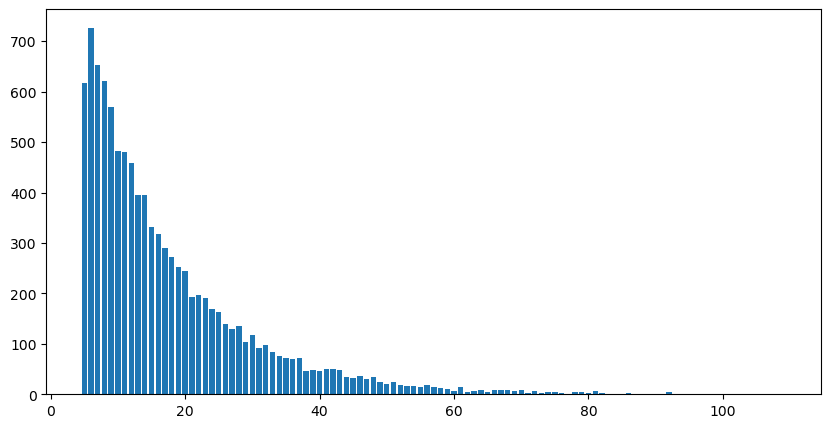

In [4]:

# Plot the number of cycles in the results as a histogram. Make the histogram wider by setting the figsize parameter.
fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(results_grouped["cycles"], height=results_grouped["count"])
plt.show()

In [5]:
# compute the expected number of cycles
expected_cycles = results["cycles"].mean()
print("Expected number of cycles: ", expected_cycles)

Expected number of cycles:  17.5016


In [6]:
# Compute the distribution of the number of cycles
# find the missing values

## Getting the distribution that fits the model

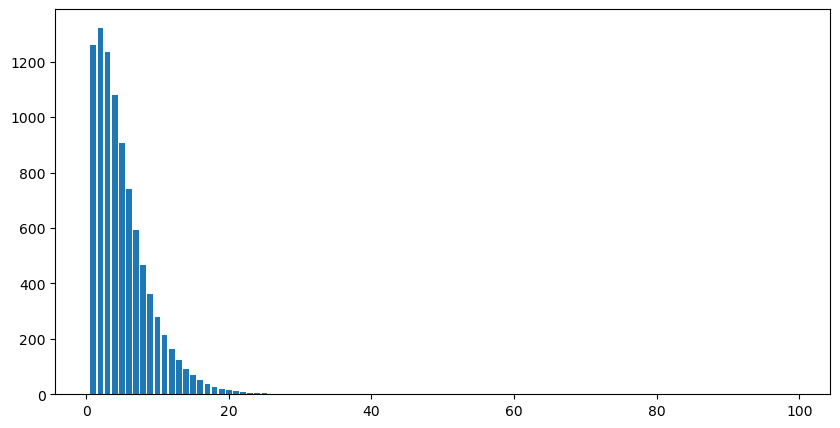

In [33]:
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import geom, nbinom

# fit the data to the geometric distribution
rv = nbinom(2,0.3)
nums = np.arange(1, 100)

# plot the results as a histogram
fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(nums, height=rv.pmf(nums)*10000)
plt.show()


In [ ]:
f = Fitter(results["cycles"].values,
           distributions= ['nbinom'])
f.fit()
f.summary()

## Markov chain fitting

In [157]:
from markov_chain_game import MarkovChainGame

chain = MarkovChainGame(A_start=4, B_start=4, pot=2)

In [181]:
# run the simulation for upto 100 turns
simulation = chain.compute_probabilities(100)
simulation.round(3)

array([0.   , 0.   , 0.438, 0.209, 0.128, 0.081, 0.052, 0.033, 0.021,
       0.014, 0.009, 0.006, 0.004, 0.002, 0.001, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

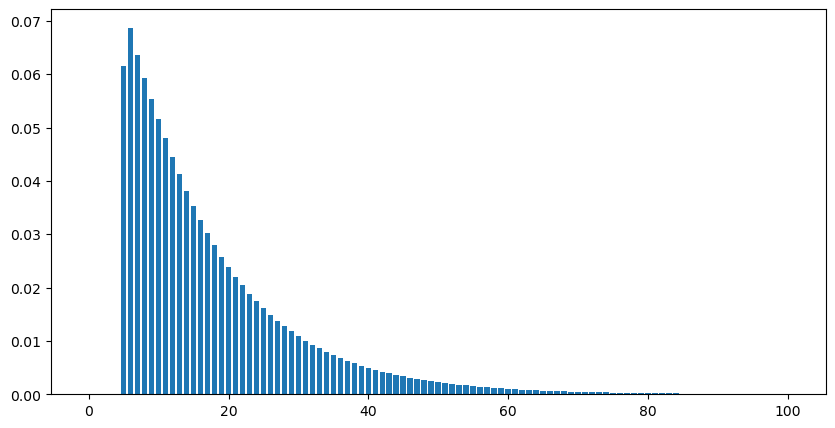

In [159]:

fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(np.arange(len(simulation) ), height=simulation)
plt.show()